# QNN for AdHoc Dataset 100
## Prepare data

In [81]:
import concurrent
import multiprocessing
import time
from qiskit import IBMQ
import pandas as pd
import numpy as np
from IPython.core.display_functions import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM, SLSQP
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal, PauliFeatureMap
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


## Provide configuration options for the learning process
---

In [67]:
RANDOM_SEED = 42
SHOTS = 1024
TRAIN_DATA_SPLIT = 0.75
FOLDS = 10

## Prepare and analyze dataset
---

In [68]:
df = pd.read_csv('datasets/adhoc_100.csv', index_col=0)
df.count()

feature_1    100
feature_2    100
label        100
dtype: int64

In [69]:
display(df)

,feature_1,feature_2,label
0,2.953097,2.324779,0.0
1,1.382301,4.021239,0.0
2,5.592035,5.152212,0.0
3,4.084070,1.130973,0.0
4,5.906194,2.827433,0.0
...,...,...,...
95,3.581416,1.822124,1.0
96,4.963716,1.130973,1.0
97,5.215044,4.712389,1.0
98,4.586725,2.324779,1.0


In [70]:
print(f'Rows with label = 1: #{df.where(df["label"] == 1.0)["label"].count()}')
print(f'Rows with label = 0: #{df.where(df["label"] == 0.0)["label"].count()}')

feature_dimension = df.shape[1] - 1
print(f"Feature dimension: {feature_dimension}")

Rows with label = 1: #50
Rows with label = 0: #50
Feature dimension: 2


In [71]:
# Split the data into training and test sets
all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=TRAIN_DATA_SPLIT, random_state=RANDOM_SEED)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Setup quantum circuit
---

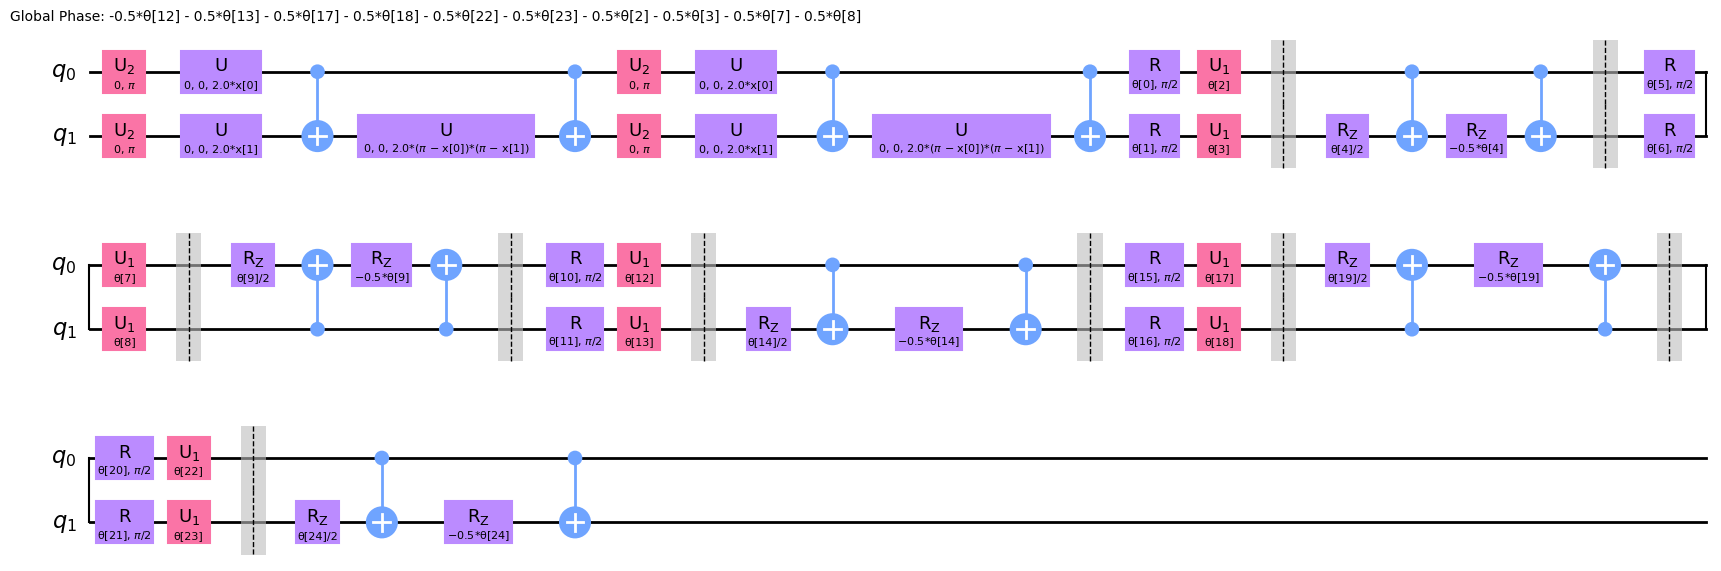

In [72]:
algorithm_globals.random_seed = RANDOM_SEED

quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), shots=SHOTS)

feature_map = ZZFeatureMap(feature_dimension=feature_dimension, entanglement='linear')
# feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=5, paulis=['Z', 'XX'])
# ansatz = RealAmplitudes(num_qubits=feature_map.num_qubits, insert_barriers=True, reps=5)
# ansatz = TwoLocal(num_qubits=feature_map.num_qubits,  reps=5, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', insert_barriers=True, skip_final_rotation_layer=False)
ansatz = TwoLocal(num_qubits=feature_map.num_qubits,  reps=5, rotation_blocks=['ry', 'rz'], entanglement_blocks='crz', entanglement= 'sca', insert_barriers=True, skip_final_rotation_layer=True)
qc = QuantumCircuit(ansatz.num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.decompose().decompose().draw(output='mpl')

In [73]:
def parity(x):
    # return "{:b}".format(x)[0] == '1'
    return "{:b}".format(x).count("1") % 2


sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=2 ** qc.num_qubits,
    interpret=parity,
)

In [74]:
objective_func_vals = []

def callback_print(_weights, obj_func_eval):
    #clear_output(wait=True)
    #objective_func_vals.append(obj_func_eval)
    print(obj_func_eval)

models = [
    NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=100),
    # optimizer=ADAM(maxiter=500),
    # optimizer=SLSQP(maxiter=250),
    callback=callback_print
    ) for fold in range(FOLDS)
]

futures = []
training_times = []

# Train the model
k_fold = KFold(n_splits=FOLDS)
with concurrent.futures.ThreadPoolExecutor() as executor:
    for i, (train_index, test_index) in enumerate(k_fold.split(train_features)):
        model = models[i]
        current_start = time.time()
        current_train_features = train_features.iloc[train_index].to_numpy()
        current_train_labels = train_labels.iloc[train_index].to_numpy()
        futures.append(executor.submit(model.fit,current_train_features, current_train_labels.astype("int")))
        futures[i].add_done_callback(lambda _: training_times.append(time.time() - current_start))
    executor.shutdown(wait=True)
    models = [future.result() for future in futures]




0.4043291492481449
0.4219793407015762
0.36481557620626803
0.3759590583311276
0.39417223110386324
0.37099717152649286
0.36095677820137634
0.3627534691349722
0.42883163729516105
0.3691404067585739
0.389901505160575
0.38575961164458783
0.38129733408870736
0.42779616712074336
0.38580318759004145
0.32573358465632896
0.4162559054986321
0.36637036786762717
0.36534300635504624
0.35037852011112125
0.35215810906729067
0.4335526770833834
0.3794462846496458
0.32573358465632896
0.32573358465632896
0.325733584656329
0.4459868068024563
0.3327294230183289
0.3326396242713315
0.3421358636337849
0.332548239392606
0.31774592597813317
0.3193692985782743
0.3344298098826143
0.3212313136950408
0.32457669064230565
0.3244382304737395
0.3242216776006514
0.3223073892384628
0.32710464651085164
0.32062934211096195
0.34416787144020666
0.31878539685110613
0.3564218956608784
0.32164569962654194
0.3313152864944082
0.3219531503023639
0.33234876683302694
0.3185892637899207
0.3231074310338699
0.31774592597813317
0.3269813

In [83]:


scores = []

for model in models:
    scores.append(model.score(test_features, test_labels))

time_splits = []

for idx, time in enumerate(training_times):
    if (idx == 0): time_splits.append(training_times[idx])
    else :
        time_splits.append(training_times[idx] - training_times[idx-1])

print(f"Scores: {scores}")
print(f'Times: {time_splits}')
print(f'Average Training Time: {np.array(time_splits).mean()}')


Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0, 1.0, 1.0]
Times: [47.55185413360596, 48.26963806152344, 48.41213870048523, 48.540996074676514, 48.51286220550537, 49.35316514968872, 49.2550003528595, 49.13232898712158, 48.892234325408936, 49.01341223716736]
Average Training Time: 48.69336302280426


## Run on Cloud Quantum Computer
---

In [84]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

max_score = 0
max_index = 0
for index, score in enumerate(scores):
    #print(index, score)
    if score > max_score:
        max_score = score
        max_index = index

print('Max index: ', max_index)
print('Max score: ', max_score)

quantum_scores=[]

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='zhaw-1')
backend = least_busy(provider.backends(simulator=False))
print(f"Chosen backend: {backend}")
for model in models:
    model.quantum_instance = QuantumInstance(backend, shots=1024)
    quantum_scores.append(model.score(test_features, test_labels))
print(f"Quantum scores: {quantum_scores}")

Max index:  0
Max score:  1.0


ibmqfactory.load_account:WARNING:2023-01-15 00:54:54,820: Credentials are already in use. The existing account in the session will be replaced.


Chosen backend: ibmq_jakarta
Quantum scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 1.0, 1.0, 1.0]
